# CCLM2 Nature Futures
-----------------
Produces Fig. 7 and supplementary Figs. 6-8

In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import mplotutils as mpu # helper functions for cartopy and matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

# Custom settings and functions
from settings import *
from plotting import *
from func_calc import *
from func_stats import *
from func_plots import *

# Mute warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
set_plot_param()
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'facecolor': '1'} # display figues as exported to PDF without 'tight'

# Settings

In [3]:
# Save to
os.makedirs('Figures/decomposition', exist_ok=True)

In [4]:
# Area for weighted mean
surf_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/surf.nc')
area = surf_ssp1.AREA

# Mask of potentially modified grid cells, based on EUNIS habitat mapping area (EU+)
eunis = xr.open_dataarray(dpath_proc + 'eunis_mask_repr.nc')

# Region mask
mask_2D = xr.open_dataarray(dpath_proc + 'regionmask_2D_Dou.nc')
mask_3D = xr.open_dataarray(dpath_proc + 'regionmask_3D_Dou.nc')
region_dict = {0: 'North', 1: 'West', 2: 'East', 3: 'South'}

# Combine subregins and EU+ into one mask
eunis_mask = xr.where(eunis==1, True, False).rename('EU+') # convert to a boolean mask
eunis_mask = eunis_mask.expand_dims('region').assign_coords(region=['EU+']) # add region dimension
mask_3D_eu = xr.concat([eunis_mask, mask_3D], dim='region') # combine to joint mask

In [5]:
# How big is the sample size per region? (10,000-65,000 grid cells)
# 1% min and max affected area (weighted quantile); ~600 grid cells -> 9000 samples across 15 years
mask_3D_eu.sum(dim=['lat','lon']).to_pandas()

region
EU+      65849
North    19876
West     16768
East     16221
South    10060
dtype: int64

# Functions

In [6]:
# Surface energy balance
aux_vars = ['z0m','EF','TLAI','QIRRIG']
in_vars = ['TBOT', 'TSKIN', 'T_2M', 'SWdown', 'SWup', 'LWdown', 'LWup', 'LH', 'SH']
seb_vars = ['Ta', 'T2m', 'Tskin', 'SWdown', 'SWup', 'LWdown', 'LWup', 'LH', 'SH', 'R', 'Albedo', 'Ea'] # 'Ta', 'TSA', 'EF', 'ET', 'ALBEDO', 

# Constants
sigma = 5.67e-8 # Stefan Boltzman constant (Wm² K^-4)
Es = 1          # surface emissivity is assumed constant = 1

In [7]:
# Change temperature units from °C to K, calculate additional variables
def process_seb(ds):
    T_vars = ['TBOT', 'TSA', 'TSKIN', 'T_2M', 'T_G'] # in °C
    with xr.set_options(keep_attrs=True): # to preserve the units
        for T_var in T_vars:
            if T_var in list(ds.keys()):
                ds[T_var] = (ds[T_var]+273.15).assign_attrs(units='K')  # convert to K
    ds = ds.rename({'TBOT': 'Ta', 'T_2M': 'T2m', 'TSKIN': 'Tskin'})
    ds['R'] = ds.SWdown - ds.SWup + ds.LWdown - ds.LWup - ds.SH - ds.LH # SEB residual (primarily ground heat flux and storage, including snow melt)
    ds['Albedo'] = ds.SWup/ds.SWdown                                    # Surface albedo
    ds['Ea'] = ds.LWdown/(sigma*ds.Ta**4)                               # Optional: atmospheric emissivity (to split LWdown into Ea and Ta)
    return ds

# Mask reference (SSP1) with min/max affected cells of each case (case-ssp1)
def mask_ref(case, mask_min, mask_max):
    ref_case = ds.sel(case=f'ref_{case}')
    mask_min_case = mask_min.sel(case=f'{case}-ssp1', drop=True)
    mask_max_case = mask_max.sel(case=f'{case}-ssp1', drop=True)
    ref_min = ref_case.where(mask_min_case==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min']})
    ref_max = ref_case.where(mask_max_case==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max']})
    return [ref_min, ref_max]

# Data processing (seasonal, JJA)

In [8]:
season = 'JJA'

# Climatology
file = 'cclm2_seasonal-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).sel(season=season, drop=True)[in_vars + aux_vars]
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file).sel(season=season, drop=True)[in_vars + aux_vars]
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file).sel(season=season, drop=True)[in_vars + aux_vars]
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file).sel(season=season, drop=True)[in_vars + aux_vars]

ds_ssp1 = process_seb(ds_ssp1)
ds_nfn = process_seb(ds_nfn)
ds_nfs = process_seb(ds_nfs)
ds_nac = process_seb(ds_nac)

ds = xr.concat([ds_ssp1[seb_vars + aux_vars],
                ds_ssp1[seb_vars + aux_vars],
                ds_ssp1[seb_vars + aux_vars],
                ds_nfn[seb_vars + aux_vars]-ds_ssp1[seb_vars + aux_vars],
                ds_nfs[seb_vars + aux_vars]-ds_ssp1[seb_vars + aux_vars],
                ds_nac[seb_vars + aux_vars]-ds_ssp1[seb_vars + aux_vars]], dim='case').assign_coords({'case': ('case', ['ref_nfn','ref_nfs','ref_nac','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
ds = ds.where(eunis==1)

# Regions
ds_reg = ds.weighted(mask_3D_eu*area.fillna(0)).mean(['lat','lon'])

# 1% min and max affected area (weighted quantile); ~600 grid cells
ds_min_mask = ds['T2m'].sel(case=slice('nfn-ssp1','nac-ssp1')).where(ds['T2m']<ds['T2m'].weighted(area.fillna(0)).quantile(0.01, dim=['lat','lon']).drop_vars('quantile'))
ds_min_mask = xr.where(ds_min_mask.notnull(), 1, 0)
ds_max_mask = ds['T2m'].sel(case=slice('nfn-ssp1','nac-ssp1')).where(ds['T2m']>ds['T2m'].weighted(area.fillna(0)).quantile(0.99, dim=['lat','lon']).drop_vars('quantile'))
ds_max_mask = xr.where(ds_max_mask.notnull(), 1, 0)
# Apply mask to cases (diff case-ssp1)
cases_min = ds.where(ds_min_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min']})
cases_max = ds.where(ds_max_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max']})
# Apply case mask to ref per case
ref_min_nfn, ref_max_nfn = mask_ref('nfn', ds_min_mask, ds_max_mask)
ref_min_nfs, ref_max_nfs = mask_ref('nfs', ds_min_mask, ds_max_mask)
ref_min_nac, ref_max_nac = mask_ref('nac', ds_min_mask, ds_max_mask)
# Combine cases
ds_min = xr.concat([ref_min_nfn, ref_min_nfs, ref_min_nac, cases_min], dim='case')
ds_max = xr.concat([ref_max_nfn, ref_max_nfs, ref_max_nac, cases_max], dim='case')
# Combine regions
jja_mean = xr.concat([ds_reg, ds_min, ds_max], dim='region')

In [9]:
# Series (for plots with CI)
file = 'cclm2_seasonal-series.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[in_vars]
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[in_vars]
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[in_vars]
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[in_vars]

season_mask = (ds_ssp1.time.dt.season==season)
ds_ssp1 = ds_ssp1.isel(time=season_mask).groupby('time.year').mean() # format time dim as year
ds_nfn = ds_nfn.isel(time=season_mask).groupby('time.year').mean()
ds_nfs = ds_nfs.isel(time=season_mask).groupby('time.year').mean()
ds_nac = ds_nac.isel(time=season_mask).groupby('time.year').mean()

ds_ssp1 = process_seb(ds_ssp1)
ds_nfn = process_seb(ds_nfn)
ds_nfs = process_seb(ds_nfs)
ds_nac = process_seb(ds_nac)

ds = xr.concat([ds_ssp1[seb_vars],
                ds_ssp1[seb_vars],
                ds_ssp1[seb_vars],
                ds_nfn[seb_vars]-ds_ssp1[seb_vars],
                ds_nfs[seb_vars]-ds_ssp1[seb_vars],
                ds_nac[seb_vars]-ds_ssp1[seb_vars]], dim='case').assign_coords({'case': ('case', ['ref_nfn','ref_nfs','ref_nac','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
ds = ds.where(eunis==1)

# Regions
ds_reg = ds.weighted(mask_3D_eu*area.fillna(0)).mean(['lat','lon'])
# Min/max affected based on climatology
cases_min = ds.where(ds_min_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min']})
cases_max = ds.where(ds_max_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max']})
# Apply case mask to ref per case
ref_min_nfn, ref_max_nfn = mask_ref('nfn', ds_min_mask, ds_max_mask)
ref_min_nfs, ref_max_nfs = mask_ref('nfs', ds_min_mask, ds_max_mask)
ref_min_nac, ref_max_nac = mask_ref('nac', ds_min_mask, ds_max_mask)
# Combine cases
ds_min = xr.concat([ref_min_nfn, ref_min_nfs, ref_min_nac, cases_min], dim='case')
ds_max = xr.concat([ref_max_nfn, ref_max_nfs, ref_max_nac, cases_max], dim='case')
# Combine regions
ds = xr.concat([ds_reg, ds_min, ds_max], dim='region')

# Surface temperature decomposition  
Luyssaert 2018   
Direct surface: LH, SH, G, Albedo  
Atmospheric feedbacks: SWin, LWin  
(Atmospheric advection/circulation: residual)  

In [10]:
# Surface emissivity is assumend constant
# Emissivities in CLM:
# bare soil:  0.97
# water:      0.97
# snow:       0.96
# vegetation: 1 - exp(-(elai + esai))

# Emissivities in COSMO:
# min-max grid cell: 0.950-0.995
# median: 0.989, mean: 0.986

## Barplot all scenarios with CI (Fig. 7)

In [11]:
def proc_case(ds, case, contributions):
    # Convert to dataframe
    df = ds.sel(case=f'{case}-ssp1', drop=True).to_dataframe(dim_order=['region','year'])
    df.columns = ['d' + name for name in df.columns]
    df_ref = ds.sel(case=f'ref_{case}', drop=True).to_dataframe(dim_order=['region','year'])
    
    # Surface tempearture sensitivity to 1 Wm-2
    term = 1/ (4*Es*sigma*df_ref.Tskin**3)
    
    # Split LWdown into emissivity and Ta changes (they mostly compensate each other, so not so interesting to split)
    data = df[['dTa', 'dT2m', 'dTskin']].rename(columns={'dTa': 'ΔTa', 'dT2m': 'ΔT2m', 'dTskin': 'ΔTskin'})
    with pd.option_context("mode.copy_on_write", True):
        data['LH'] = term * -df.dLH
        data['SH'] = term * -df.dSH
        data['G'] = term * -df.dR
        data['Albedo'] = term * -df_ref.SWdown * df.dAlbedo
        data['SWdown'] = term * (1 - df_ref.Albedo) * df.dSWdown
        #data['Ea'] = term * Es*sigma*(df_ref.Ta**4) * df.dEa
        #data['Ta'] = term * 4*Es*df_ref.Ea*sigma*(df_ref.Ta**3) * df.dTa
        #data['Sum'] = data.loc[:,['LH','SH','R','Albedo','SWdown','Ea','Ta']].sum(axis=1)
        #data['Sum surface'] = data.loc[:,['LH','SH','R','Albedo']].sum(axis=1)
        #data['Sum atmos'] = data.loc[:,['SWdown','Ea','Ta']].sum(axis=1)
        data['LWdown'] = term * df.dLWdown # can be used instead of Ea and Ta
        data['Sum'] = data.loc[:,['LH','SH','G','Albedo','SWdown','LWdown']].sum(axis=1)
        data['Sum surface'] = data.loc[:,['LH','SH','G','Albedo']].sum(axis=1)
        data['Sum atmos'] = data.loc[:,['SWdown','LWdown']].sum(axis=1)
    
    # Prepare data for plotting
    ci = confidence_interval(data, group_dim='region', confidence=0.95)
    mean = data.groupby('region').mean()

    return [mean, ci]

In [12]:
def plot_single(ax, reg):
    bars = mean.loc[reg,contributions].plot(ax=ax, kind='bar', width=1, color=[colordict[c] for c in contributions], rot=0, zorder=0, legend=False);
    for i, bar in enumerate(bars.patches): # add error bars manually with matching colors
        err = ci.loc[reg, contributions[i]]
        ax.errorbar(bar.get_x() + bar.get_width()/2, bar.get_height(), yerr=err, fmt='none', ecolor=bar.get_facecolor(), elinewidth=0.7, capsize=0, zorder=3)
    ax.scatter(6, mean.loc[reg,'ΔTskin'], marker='_', color='black', s=7, linewidth=0.5, zorder=5) # add scatter with error bars
    ax.scatter(6, mean.loc[reg,'ΔT2m'], marker='+', color='black', s=7, linewidth=0.5, zorder=5)
    ax.errorbar([7,7.5], mean.loc[reg,['Sum surface','Sum atmos']], yerr=ci.loc[reg,['Sum surface','Sum atmos']], fmt='o', color='black', markersize=1, linewidth=0.5, zorder=5)

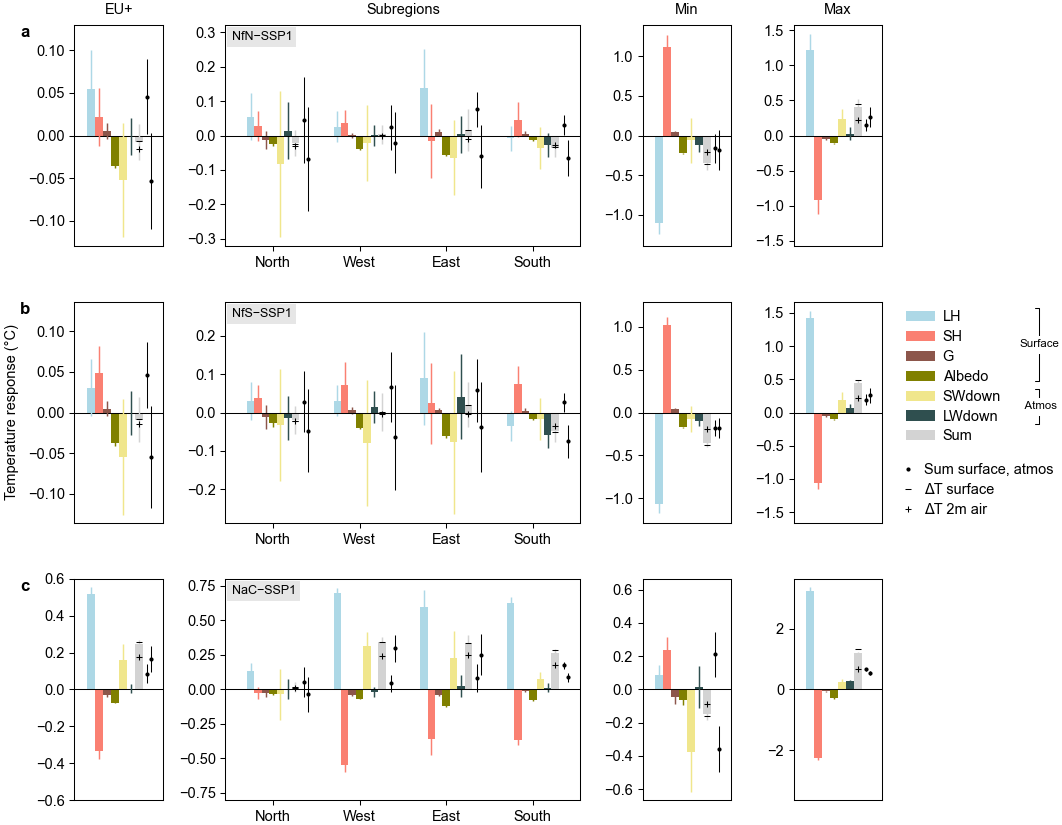

In [13]:
titles = ['EU+', 'Subregions', 'Min', 'Max']
contributions = ['LH', 'SH', 'G', 'Albedo', 'SWdown', 'LWdown', 'Sum'] # 'ΔTskin', 'ΔT2m', 'ΔTa'
colordict = {'LH': 'lightblue', 'SH': 'salmon', 'G': 'tab:brown', 'Albedo': 'olive', 'SWdown': 'khaki', 'LWdown': 'darkslategrey', 'Sum': 'lightgrey'}

fig, all_axes = plt.subplots(3,4, figsize=(double_width,5.5), width_ratios=(0.75,3,0.75,0.75), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.25, wspace=0.4, left=0.07, right=0.83, bottom=0.03, top=0.97)

for i,case in enumerate(['nfn','nfs','nac']):
    axes = all_axes[i,:]

    # Prepare data
    mean, ci = proc_case(ds, case, contributions)

    # Plot
    ax = axes[0]
    reg = 'EU+'
    plot_single(ax, reg)
    
    ax = axes[1]
    reg = ['North', 'West', 'East', 'South']
    width = 0.6
    dodge_width = width - width/(len(reg)+3)
    bars = mean.loc[reg,contributions].plot(ax=ax, kind='bar', width=width, color=[colordict[c] for c in contributions], rot=0, zorder=0);
    handles, labels = ax.get_legend_handles_labels() # save for later
    ax.get_legend().remove() # avoid legend be drawn per case
    for i, container in enumerate(bars.containers): # add error bars manually using bar containers (contributions), for each contribution i with matching colors
        if i >= len(contributions):
            break  # avoid index error if more containers than contributions
        for j, bar in enumerate(container):
            if j >= len(reg):
                continue  # avoid index error if more bars than regions
            err = ci.loc[reg[j], contributions[i]]
            ax.errorbar(bar.get_x() + bar.get_width()/2, bar.get_height(), yerr=err, fmt='none', ecolor=bar.get_facecolor(), elinewidth=0.7, capsize=0, zorder=0)
    xloc = bars.containers[6][0].get_x() + bars.containers[6][0].get_width()/2 # get xlocation of the sum bar
    ax.scatter([r+xloc for r in [0,1,2,3]], mean.loc[reg,'ΔTskin'], marker='_', color='black', s=7, linewidth=0.5, zorder=5)
    ax.scatter([r+xloc for r in [0,1,2,3]], mean.loc[reg,'ΔT2m'], marker='+', color='black', s=7, linewidth=0.5, zorder=5)
    for i,r in enumerate(reg):
        ax.errorbar([i+xloc+0.1, i+xloc+0.15], mean.loc[r,['Sum surface','Sum atmos']], yerr=ci.loc[r,['Sum surface','Sum atmos']], fmt='o', color='black', markersize=1, linewidth=0.5, zorder=5)

    ax = axes[2]
    reg = 'Min'
    plot_single(ax, reg)
    
    ax = axes[3]
    reg = 'Max'
    plot_single(ax, reg)
    
    for ax in axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.axhline(0, linewidth=0.5, color='black')
        make_symmetric(ax)
    for i in [0,2,3]:
        axes[i].set_xlim(-2,9);
        axes[i].set_xticks([]);

# Format whole figure
fig.supylabel('Temperature response (°C)', x=0.005)
for i,title in enumerate(titles):
    all_axes[0,i].set_title(title, pad=5)
 
# Legends
axes = all_axes[1,:]
axes[1].legend(handles, labels, loc='upper left', frameon=False, bbox_to_anchor=(1.88,1.02)) # bar colors
legend_elements = [Line2D([0], [0], linestyle='None', marker='o', color='black', markersize=1, label='Sum surface, atmos'),
                   Line2D([0], [0], linestyle='None', marker='_', color='black', markersize=3, markeredgewidth=0.5, label='ΔT surface'),
                   Line2D([0], [0], linestyle='None', marker='+', color='black', markersize=3, markeredgewidth=0.5, label='ΔT 2m air')]
axes[3].legend(handles=legend_elements, handletextpad=0.1, loc='upper left', frameon=False, bbox_to_anchor=(0.98,0.33)) # markers

# Brackets
axes[3].annotate('Surface', xy=(2.77, 0.8), xytext=(2.77, 0.83), xycoords='axes fraction', 
            fontsize=5.5, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', linewidth=0.5, color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=3.2, lengthA=0.4, angleA=90', lw=0.5, color='k'))
axes[3].annotate(' Atmos', xy=(2.77, 0.52), xytext=(2.77, 0.55), xycoords='axes fraction', 
            fontsize=5.5, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', linewidth=0.5, color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=1.5, lengthA=0.4, angleA=90', lw=0.5, color='k'))

# Panel labels
axes = all_axes[:,0]
for i, (label,case) in enumerate(zip(['a','b','c'],['NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1'])):
    all_axes[i,0].annotate(label,
                           xy=(-0.5, 1), xycoords='axes fraction',
                           fontsize=8, font='Arial', fontweight='bold', verticalalignment='top', horizontalalignment='right')
    all_axes[i,1].annotate(case,
                           xy=(0,1), xycoords='axes fraction',
                           xytext=(+3, -3), textcoords='offset points',
                           fontsize=6, font='Arial', verticalalignment='top', horizontalalignment='left',
                           bbox=dict(facecolor='0.9', edgecolor='none', pad=2.0))

#plt.savefig('Figures/decomposition/Fig7_components_bars_ci.pdf')
plt.savefig('Figures/decomposition/Fig7_components_bars_ci.png')
plt.show()

## Maps all scenarios (Supp. Figs. 6-8)

In [14]:
def proc_case_mapping(case):
    file = 'cclm2_seasonal-climatology.nc'
    season='JJA'
    ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).sel(season=season, drop=True)
    ds_case = xr.open_dataset(dpath_proc + f'cclm2_EUR11_FB_{case}/' + file).sel(season=season, drop=True)
    ds_ssp1 = process_seb(ds_ssp1)[seb_vars] #.where(eunis==1)
    ds_case = process_seb(ds_case)[seb_vars] #.where(eunis==1)
    ds = ds_case-ds_ssp1
    ds = ds.rename({'Ta':'dTa', 'T2m':'dT2m', 'Tskin':'dTskin', 'SWdown':'dSWdown', 'SWup':'dSWup', 'LWdown':'dLWdown', 'LWup':'dLWup', 'LH':'dLH', 'SH':'dSH', 'R':'dR'})
    
    # Constants
    sigma = 5.67e-8 # Stefan Boltzman constant (Wm² K^-4)
    Es = 1          # surface emissivity is assumed constant = 1
    
    # Surface albedo
    ds_ssp1['Albedo'] = ds_ssp1.SWup/ds_ssp1.SWdown
    ds_case['Albedo'] = ds_case.SWup/ds_case.SWdown
    ds['dAlbedo'] = ds_case['Albedo'] - ds_ssp1['Albedo']
    
    # Optional: atmospheric emissivity (to split LWdown into Ea and Ta)
    ds_ssp1['Ea'] = ds_ssp1.LWdown/(sigma*ds_ssp1.Ta**4)
    ds_case['Ea'] = ds_case.LWdown/(sigma*ds_case.Ta**4)
    ds['dEa'] = ds_case['Ea'] - ds_ssp1['Ea']
    
    # Surface tempearture sensitivity to 1 Wm-2
    term = 1/ (4*Es*sigma*ds_ssp1.Tskin**3)
    
    data = ds[['dTa', 'dT2m', 'dTskin']].rename({'dTa': 'ΔTa', 'dT2m': 'ΔT2m', 'dTskin': 'ΔTskin'})
    data['LH'] = term * -ds.dLH
    data['SH'] = term * -ds.dSH
    data['G'] = term * -ds.dR
    data['Albedo'] = term * -ds_ssp1.SWdown * ds.dAlbedo
    data['SWdown'] = term * (1 - ds_ssp1.Albedo) * ds.dSWdown
    data['LWdown'] = term * ds.dLWdown
    data['Sum'] = data.LH + data.SH + data.G + data.Albedo + data.SWdown + data.LWdown
    data['Sum surface'] = data.LH + data.SH + data.G + data.Albedo
    data['Sum atmos'] = data.SWdown + data.LWdown
    #data['Ea'] = term * Es*sigma*ds_ssp1.Ta**4 * ds.dEa
    #data['Ta'] = term * 4*Es*ds_ssp1.Ea*sigma*ds_ssp1.Ta**3 * ds.dTa
    #data['Sum'] = data.LH + data.SH + data.G + data.Albedo + data.SWdown + data.Ea + data.Ta
    #data['Sum surface'] = data.LH + data.SH + data.G + data.Albedo
    #data['Sum atmos'] = data.SWdown + data.Ea + data.Ta
    #data['ΔT2m-ΔTskin'] = data.ΔT2m - data.ΔTskin
    data['Residual'] = data.ΔTskin - data['Sum'] # negligible
    return data

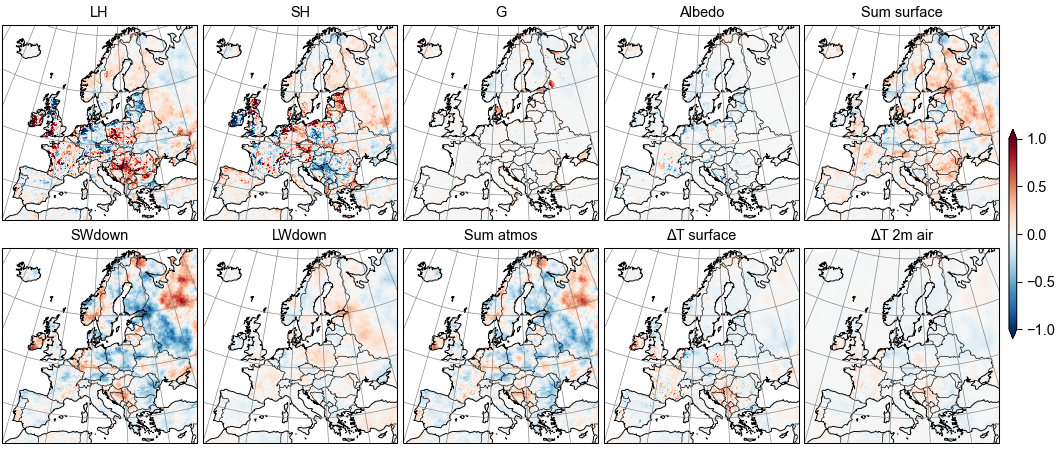

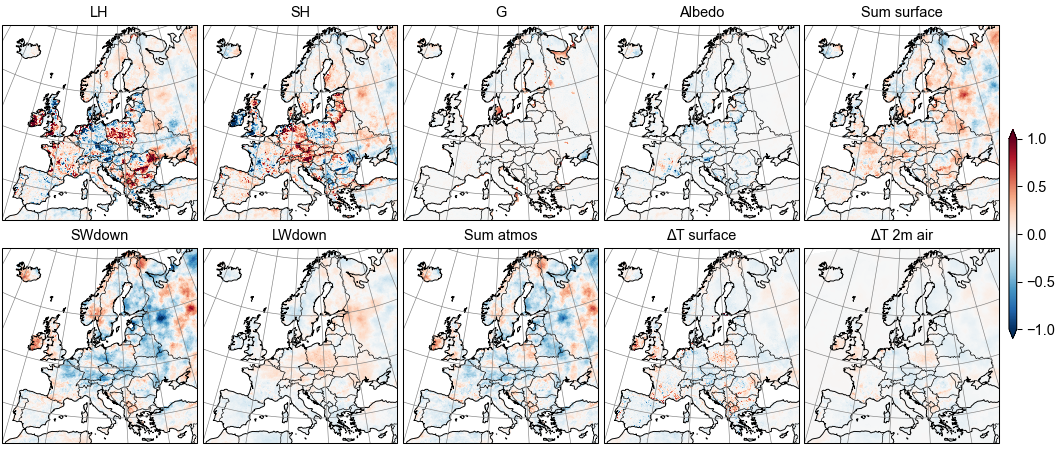

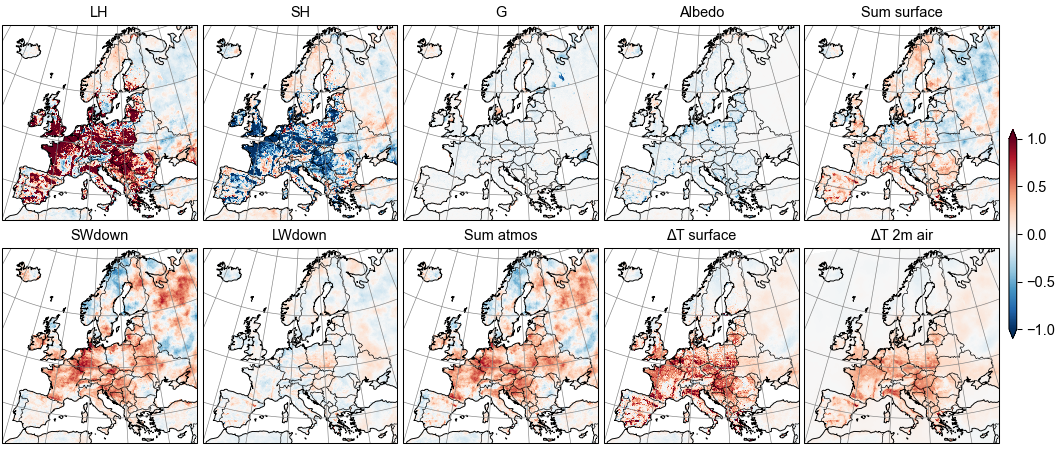

In [15]:
# Plot per case and save
variables = ['LH', 'SH', 'G', 'Albedo', 'Sum surface', 'SWdown', 'LWdown', 'Sum atmos', 'ΔTskin', 'ΔT2m']
titles = ['LH', 'SH', 'G', 'Albedo', 'Sum surface', 'SWdown', 'LWdown', 'Sum atmos', 'ΔT surface', 'ΔT 2m air']

for case in ['nfn', 'nfs', 'nac']:
    data = proc_case_mapping(case)
    fig, axes = plt.subplots(2,5, figsize=(double_width,3), subplot_kw=dict(projection=map_proj, facecolor="white"))
    axes = axes.flatten()
    format_axes(axes)
    fig.subplots_adjust(hspace=0.07, wspace=0.03, left=0.002, right=0.94, bottom=0.0, top=0.96)
    vmin=-1; vmax=1; levels=np.arange(vmin, vmax+0.01, 0.05) # levels for discrete colorbar
    opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, extend='both', cmap='RdBu_r', add_colorbar=False)
    for i,var in enumerate(variables):
        h = data[var].plot(ax=axes[i], **opt);
        axes[i].set_title(titles[i])
    cbar = mpu.colorbar(h, axes[4], axes[-1], orientation='vertical', size=0.04, shrink=0.5, extend='both', label='', pad=0.05)
    fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
    #plt.savefig(f'Figures/decomposition/SM-Figs6-8_components_maps_{case}.pdf')
    plt.savefig(f'Figures/decomposition/SM-Figs6-8_components_maps_{case}.png')

# Correlation Tskin-T2m for NaC scenario

## Maps of grid cell level correlation (Supp. Fig. 9)

In [16]:
# Correlation of Tskin and T2m change
# Per grid cell across years dT (case-ssp1)
season = 'JJA'
file = 'cclm2_seasonal-series.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).rename({'TBOT': 'Ta', 'T_2M': 'T2m', 'TSKIN': 'Tskin'})
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file).rename({'TBOT': 'Ta', 'T_2M': 'T2m', 'TSKIN': 'Tskin'})
ds_ssp1 = ds_ssp1.isel(time=(ds_ssp1.time.dt.season==season), drop=True)
ds_nac = ds_nac.isel(time=(ds_nac.time.dt.season==season), drop=True)
dTskin = (ds_nac['Tskin']-ds_ssp1['Tskin']).where(eunis==1)
dt2m = (ds_nac['T2m']-ds_ssp1['T2m']).where(eunis==1)
corr = xr.corr(dTskin, dt2m, dim='time')
corr_dt = corr.copy() # save
[corr.min().round(2).item(), corr.max().round(2).item(), corr.median().round(2).item(), corr.mean().round(2).item()]

[-0.56, 1.0, 0.94, 0.91]

In [17]:
# Correlation >0.9 in >70% of grid cells
# Correlation >0.8 in >90% of grid cells
(corr_dt.where(corr_dt>0.9).count()/corr_dt.count()).item()

0.7148172333672493

In [18]:
corr_dt.quantile(0.05).item()

0.7429916696087305

In [19]:
# Correlation of Tskin and T2m absolute
# Per grid cell across years T SSP1
file = 'cclm2_seasonal-series.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).rename({'TBOT': 'Ta', 'T_2M': 'T2m', 'TSKIN': 'Tskin'})
ds_ssp1 = ds_ssp1.isel(time=(ds_ssp1.time.dt.season==season), drop=True)
dTskin = ds_ssp1['Tskin'].where(eunis==1)
dt2m = ds_ssp1['T2m'].where(eunis==1)
corr = xr.corr(dTskin, dt2m, dim='time')
[corr.min().round(2).item(), corr.max().round(2).item(), corr.median().round(2).item(), corr.mean().round(2).item()]

[0.58, 1.0, 0.98, 0.98]

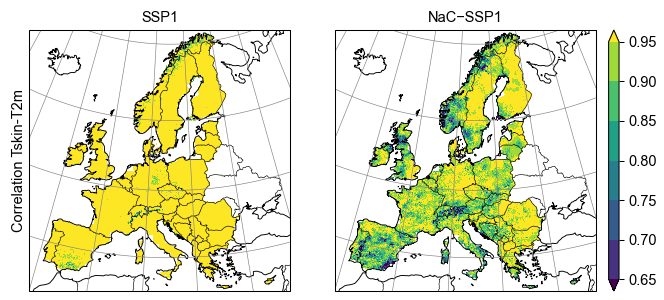

In [20]:
col_headers = ['SSP1', 'NaC−SSP1']
row_headers = ['Correlation Tskin-T2m']

fig, axes = plt.subplots(1,2, figsize=(double_width/1.6,2), subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(axes.flatten())
add_headers(fig, col_headers=col_headers, row_headers=row_headers, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
fig.subplots_adjust(hspace=0.05, wspace=0.0, left=0.01, right=0.93, bottom=0.03, top=0.9) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels
vmin=0.65; vmax=0.95; levels=np.arange(vmin, vmax+0.01, 0.05) # levels for discrete colorbar
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend='both', add_colorbar=False)

h = corr.plot(ax=axes[0], robust=True, **opt)
h = corr_dt.plot(ax=axes[1], robust=True, **opt)
cbar = mpu.colorbar(h, axes[1], orientation='vertical', size=0.04, extend='both', label='', pad=0.05)
for ax in axes:
    ax.set_title('')
fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
#plt.savefig('Figures/decomposition/SM-Fig9_corr_Tskin-T2m.pdf')
plt.savefig('Figures/decomposition/SM-Fig9_corr_Tskin-T2m.png')

## Regional correlation

In [33]:
# Regional dT
file = 'cclm2_seasonal-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).sel(season=season, drop=True)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file).sel(season=season, drop=True)
dTskin = (ds_nac['TSKIN']-ds_ssp1['TSKIN']).where(eunis==1)
dt2m = (ds_nac['T_2M']-ds_ssp1['T_2M']).where(eunis==1)

corr_list = []
corr_list.append(xr.corr(dTskin, dt2m).item()) # EU+
for i,reg in enumerate(mask_3D.region): # regions
    corr = xr.corr(dTskin.where(mask_2D==i), dt2m.where(mask_2D==i))
    corr_list.append(corr.item())
corr = pd.Series(index=['EU+', 'North', 'West', 'East', 'South'], data=corr_list)
corr_dt = corr.copy() # save

In [34]:
# Regional T SSP1
file = 'cclm2_seasonal-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).sel(season=season, drop=True)
dTskin = ds_ssp1['TSKIN'].where(eunis==1)
dt2m = ds_ssp1['T_2M'].where(eunis==1)

corr_list = []
corr_list.append(xr.corr(dTskin, dt2m).item()) # EU+
for i,reg in enumerate(mask_3D.region): # regions
    corr = xr.corr(dTskin.where(mask_2D==i), dt2m.where(mask_2D==i))
    corr_list.append(corr.item())
corr = pd.Series(index=['EU+', 'North', 'West', 'East', 'South'], data=corr_list)

In [35]:
pd.concat([corr.rename('SSP1'), corr_dt.rename('NaC−SSP1')], axis=1).round(2)

,SSP1,NaC−SSP1
EU+,0.99,0.85
North,0.99,0.84
West,0.99,0.89
East,0.99,0.89
South,0.98,0.87
